Toy dataset 02_2, to check if chunking of output zarr is affecting the FTLE calculations that Darshika is trying. (Much lower than expected)

# To dos:
* dt = -25 mins --> check 

(background in time)


# Simulation charactersitics:
* Runtime: 30 days (backwards in time).  FTCS requires thet there is enought mixing in the domain for it to detect the coherent structures.
* Particles released: SMOC spatial resolution is 1/12, so release of x4 that (1/48) to get subgrid dynamics.
* Region : west of retroflection (to have coherent eddies).

### Sample UV based on:
https://github.com/sruehs/IMMERSE_waves/blob/develop-mac/code/Parcels_CalcTraj_v2tau.ipynb

# To improve:
* add indices to not load all global dataset and increase speed

In [1]:
import matplotlib.pyplot as plt 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
import matplotlib.ticker as mticker

import xarray as xr
# import trajan as ta

In [2]:
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import math
from datetime import timedelta, datetime

from operator import attrgetter

# Exploring one input file to define region of release:

In [4]:
filedir = '/storage/shared/oceanparcels/input_data/CMEMS/GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/'

In [5]:
ds_m = xr.open_mfdataset(filedir + 'SMOC_20210[1-2]*')


In [6]:
ds_m

<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2041, depth: 1, time: 1416)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494
  * time       (time) datetime64[ns] 2021-01-01T00:30:00 ... 2021-02-28T23:30:00
Data variables:
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    vsdx       (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    vsdy       (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    utide      (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    vtide      (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    utotal     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
    vtotal     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 1, 1021, 2160), meta=np.ndarray>
Attributes: (12/19)
    product:                       GLOBAL_ANALYSIS_FORECAST_PHY_001_024
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         hourly mean merged surface currents from o...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    ...                            ...
    institution:                   MERCATOR OCEAN
    julian_day_unit:               hours since 1950-01-01 00:00:00
    latitude_min:                  -80
    latitude_max:                  90.0
    longitude_min:                 -180.0
    longitude_max:                 179.91667175293

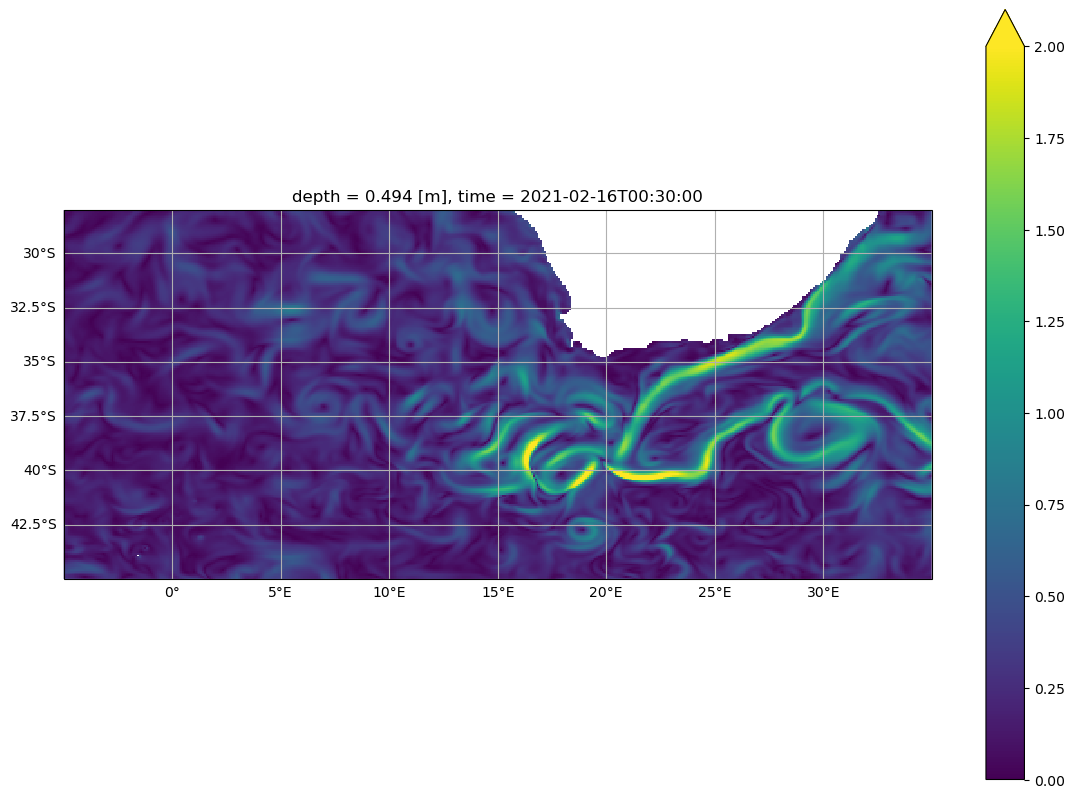

In [7]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
np.sqrt((ds_m.uo[46*24,0,:,:])**2 + (ds_m.vo[46*24,0,:,:])**2).plot(vmax=2)
# ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-5, 35])
ax1.set_ylim([-45, -28])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# Zoom in:

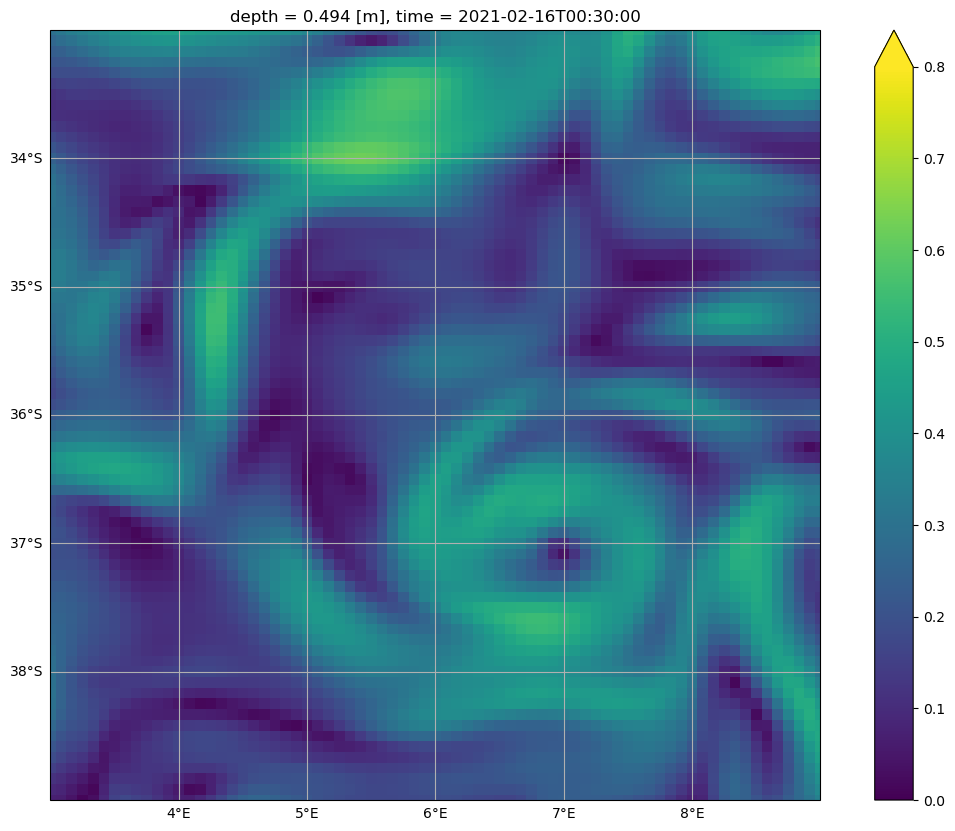

In [8]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
np.sqrt((ds_m.uo[46*24,0,:,:])**2 + (ds_m.vo[46*24,0,:,:])**2).plot(vmax=.8) #1.2)
# ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([3, 9])
ax1.set_ylim([-39, -33])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

We choose a region west of the retroflection where more coherent eddies can be observed

Checking the indices:

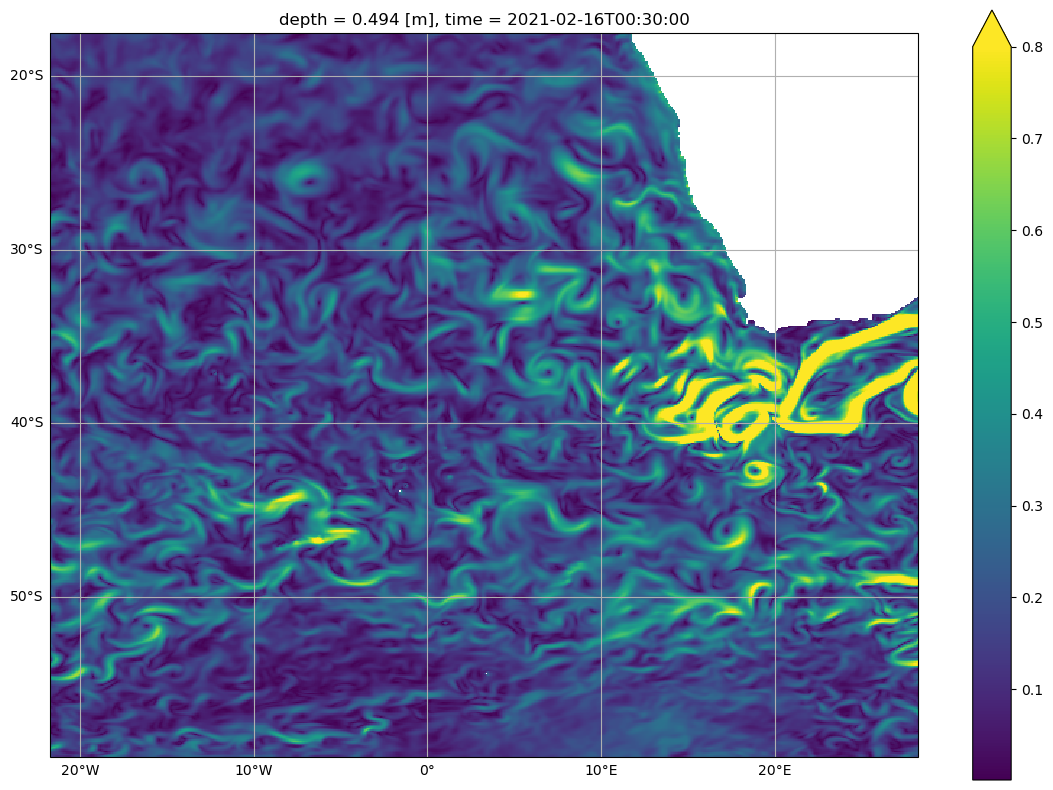

In [9]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
np.sqrt((ds_m.uo[46*24,0,250:750,1900:2500])**2 + (ds_m.vo[46*24,0,250:750,1900:2500])**2).plot(vmax=.8) #1.2)
# ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
# ax1.set_xlim([0, 12])
# ax1.set_ylim([-33-12, -33])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# Launching the simulation:

In [10]:
# Lorenz directory
filedir = '/storage/shared/oceanparcels/input_data/CMEMS/'


In [11]:
filenames = {'U': filedir + "GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210[1-2]*",
             'V': filedir + "GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20210[1-2]*"}

## we use the eulerian velocity (uo and vo):

In [12]:
variables = {'U': 'uo',
             'V': 'vo'}
dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [13]:
# fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, chunksize='auto') # --> slow with this

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices={'longitude': range(1900, 2500), 'latitude': range(250, 750)}, chunksize=False)

# Releasing particles in a regular grid:
Particles released with a resolution x4 the resolution of the input data (1/12˚), so 1/48˚.


In [14]:
lon_min = 3.
lon_max = 9.

lat_min = -39.
lat_max = -33.

In [15]:
step = 1./48

lons, lats = np.meshgrid(np.arange(lon_min, lon_max+step, step), np.arange(lat_min, lat_max+step, step))

In [16]:
pclass=JITParticle

class UVParticle(pclass):
    U = Variable('U', dtype=np.float32, initial=np.nan)
    V = Variable('V', dtype=np.float32, initial=np.nan)

In [17]:
pset = ParticleSet(fieldset=fieldset, pclass=UVParticle, lon=lons, lat=lats, time=datetime(2021, 2, 16, 0, 0)) #30


In [18]:
def DeleteParticle(particle, fieldset, time):
    particle.delete

In [19]:
def SampleUV(particle, fieldset, time):
    # attention: samples particle velocity in deg/s and needs to be converted to m/s
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

In [20]:
output_filename = "toy_data_02_2.zarr"

In [21]:

output_file = pset.ParticleFile(name=output_filename, outputdt=timedelta(hours=6))
pset.execute(pset.Kernel(AdvectionRK4) + pset.Kernel(SampleUV),
             runtime=timedelta(days=30),
             dt=timedelta(minutes=-25), # back in time
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=output_file)

INFO: Compiled ArrayUVParticleAdvectionRK4SampleUV ==> /tmp/parcels-319202/lib85845bf3b316f89ac21c1d98756b00f8_0.so
INFO: Temporary output files are stored in out-MZCIXPDV.
INFO: You can use "parcels_convert_npydir_to_netcdf out-MZCIXPDV" to convert these to a NetCDF file during the run.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2592000.0/2592000.0 [09:40<00:00, 4464.70it/s]


In [22]:
output_file.export()


In [24]:
ds = xr.open_dataset(output_filename)

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [25]:
ds

<xarray.Dataset>
Dimensions:     (traj: 84100, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    z           (traj, obs) float32 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.2-3-g366d4707

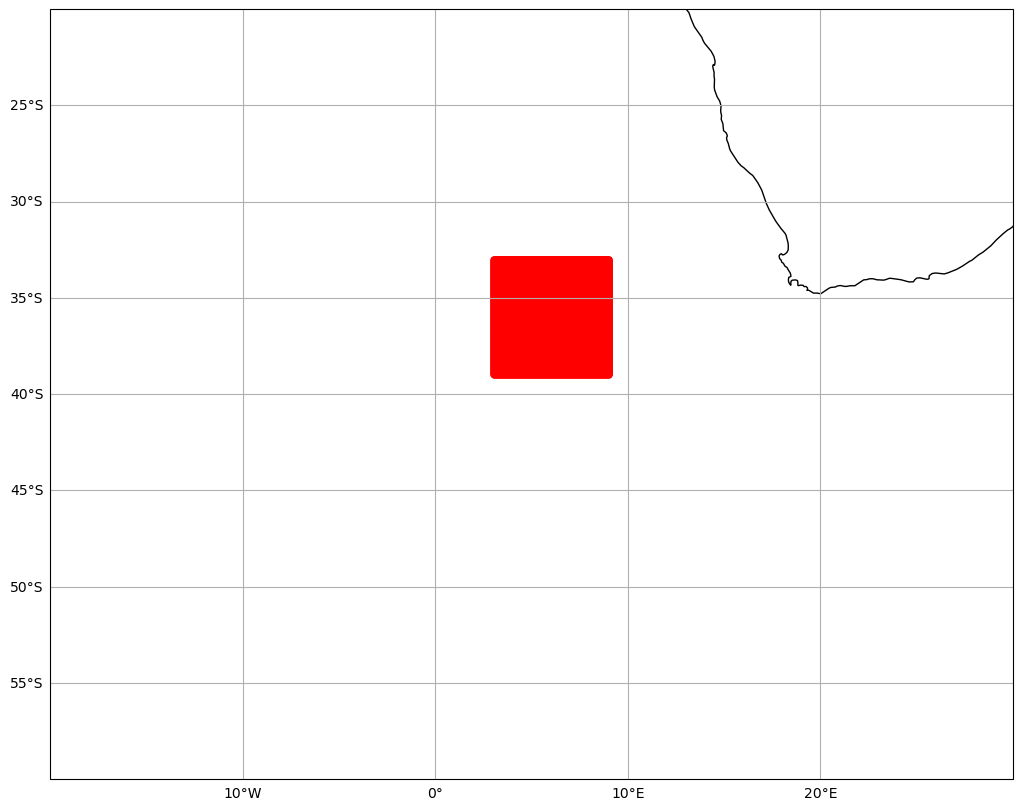

In [26]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-20, 30])
ax1.set_ylim([-60, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

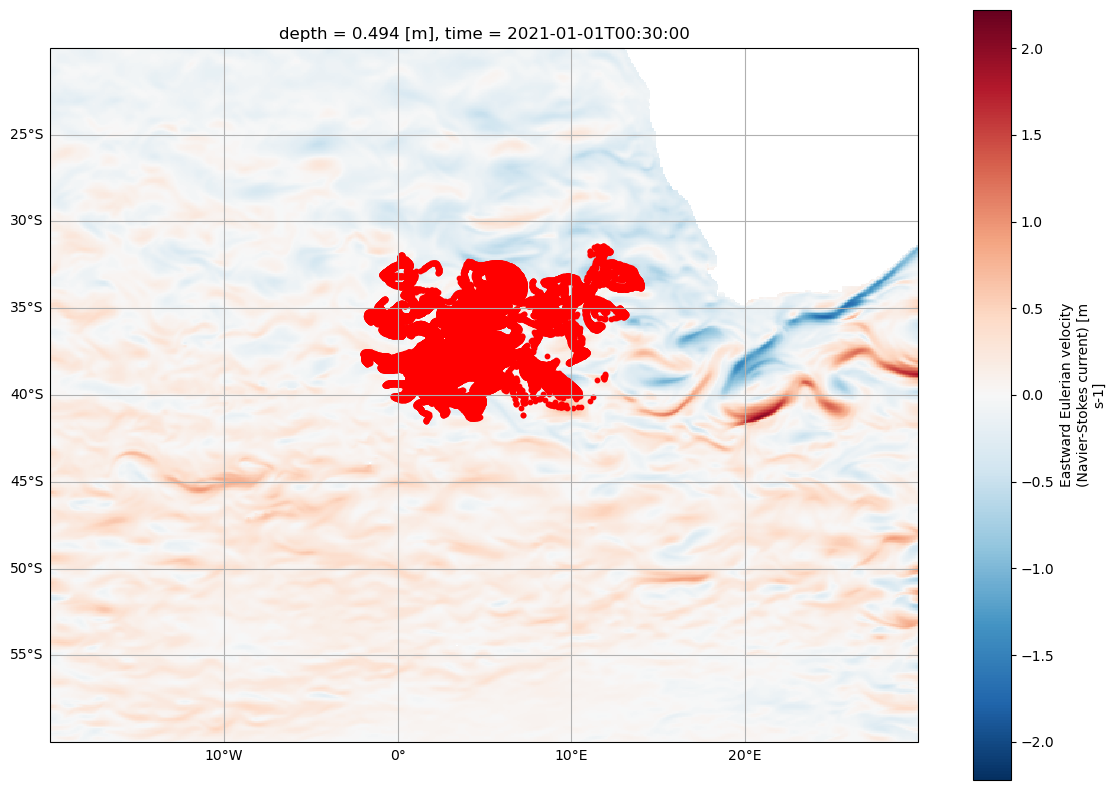

In [27]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
# ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ds_m.uo[0,0,:,:].plot()
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=10, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-20, 30])
ax1.set_ylim([-60, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# Plotting 1/100 trajectories:

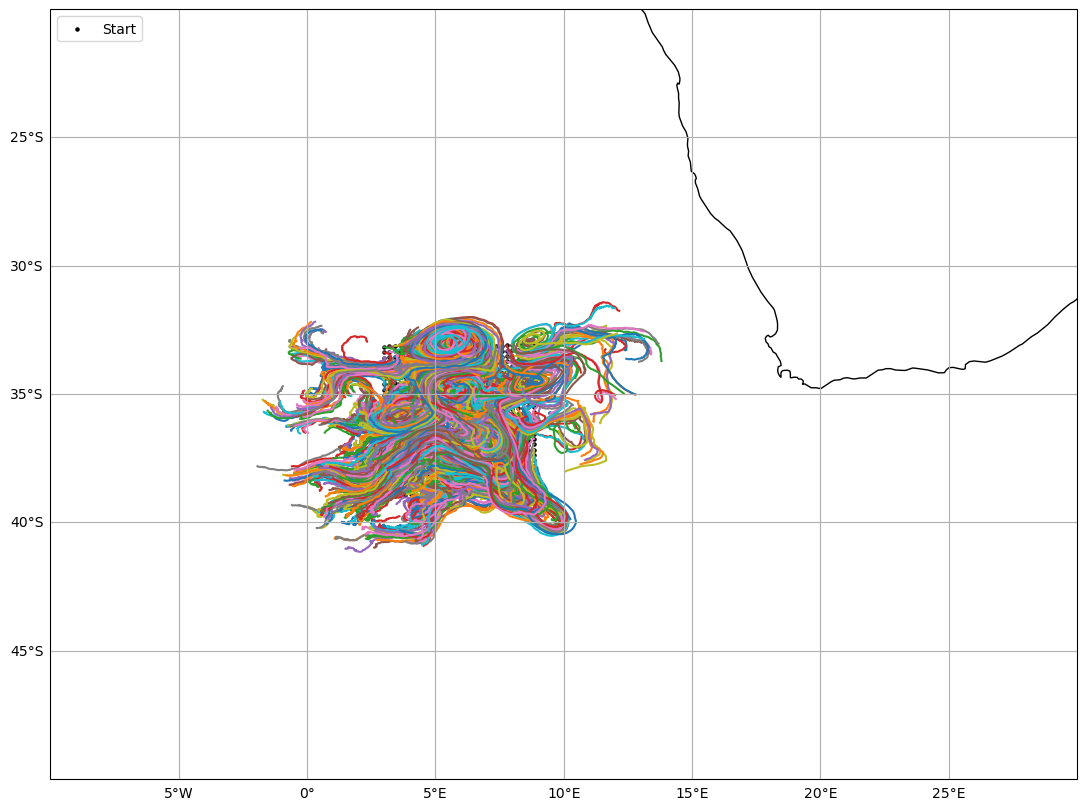

In [28]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds['lon'][0::100,:].T, ds['lat'][0::100,:].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds['lon'][0::100,0], ds['lat'][0::100,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-10, 30])
ax1.set_ylim([-50, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# ax1.set_title('0m', size=12)
ax1.legend(loc=2)

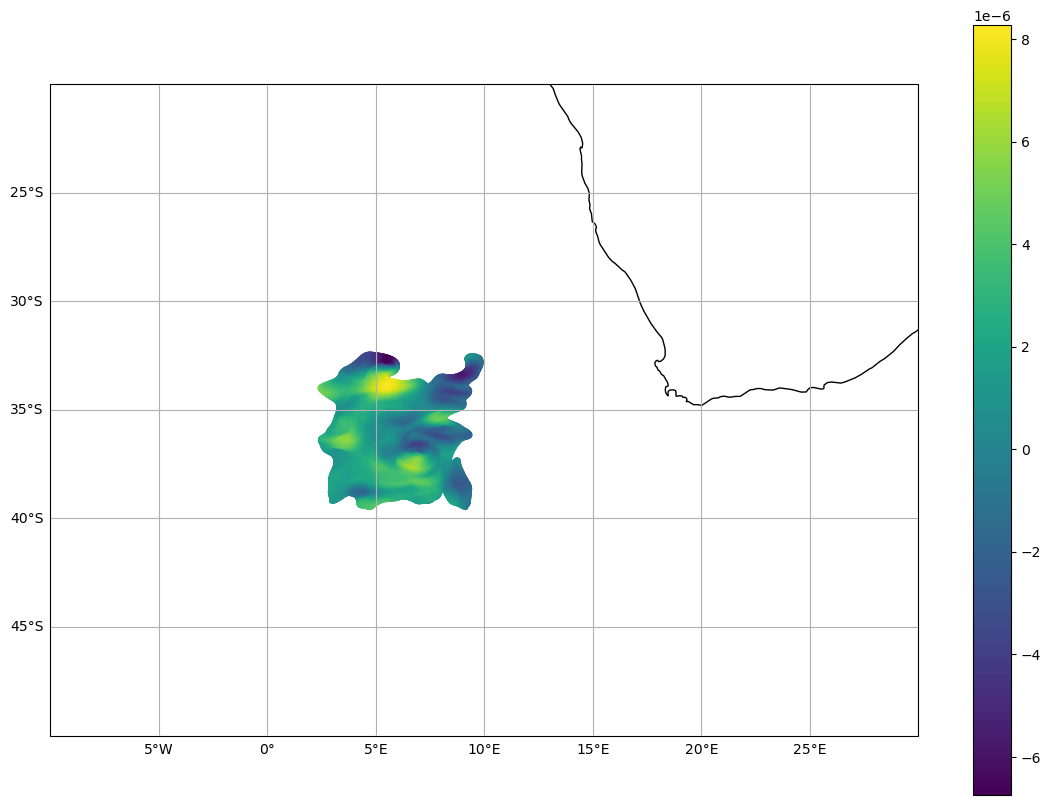

In [29]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
cc = ax1.scatter(ds['lon'][:,10], ds['lat'][:,10], c=ds.U[:,10], s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-10, 30])
ax1.set_ylim([-50, -20])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc)
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

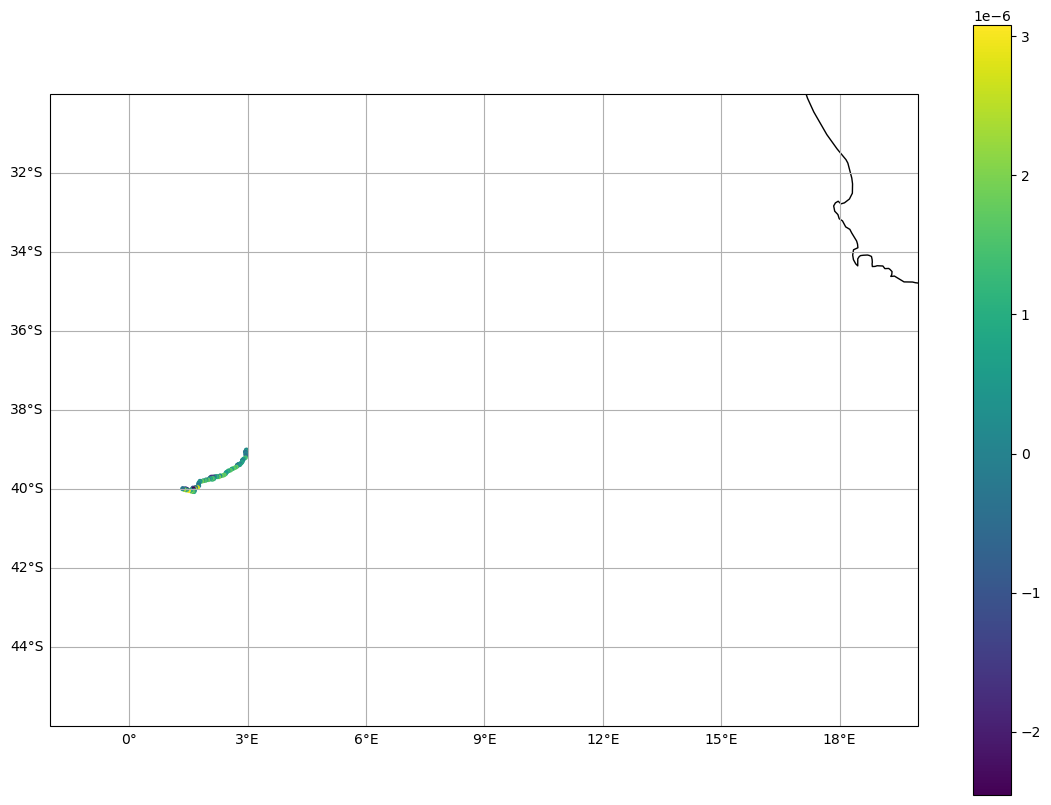

In [30]:
plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
cc = ax1.scatter(ds['lon'][0,:], ds['lat'][0,:], c=ds.U[0,:], s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-2, 20])
ax1.set_ylim([-46, -30])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc)
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

# --> units in degrees/s

In [31]:
def calc_trajspeed(trajset):
    """
    Obtain vel. in m/s
    1852*60 is ....
    """
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60 
    speed = (u**2 + v**2)**(1/2)
    return speed

In [32]:
speed = calc_trajspeed(ds)


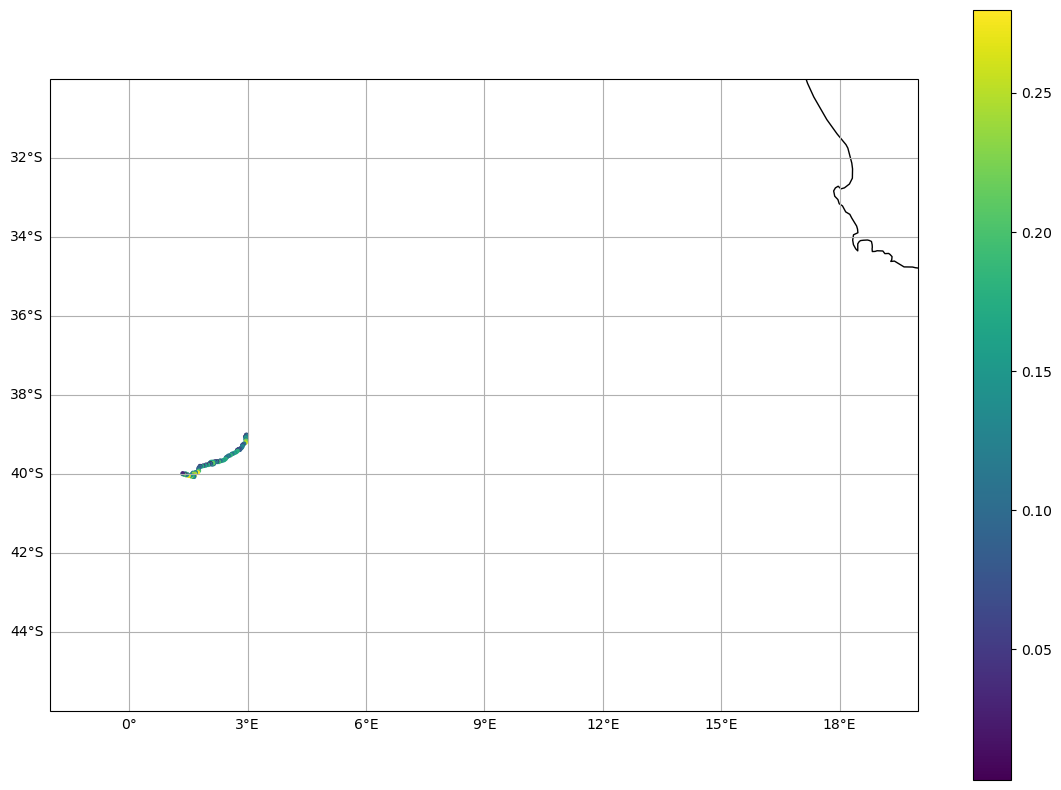

In [33]:

plt.figure(figsize=(14,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
cc = ax1.scatter(ds['lon'][0,:], ds['lat'][0,:], c=speed[0,:], s=5, transform=ccrs.PlateCarree(), label='Start') #marker='o'
ax1.set_xlim([-2, 20])
ax1.set_ylim([-46, -30])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
# gl.ylocator = mticker.FixedLocator([54, 55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc)
# ax1.set_title('0m', size=12)
# ax1.legend(loc=2)

In [34]:
speed

<xarray.DataArray (traj: 84100, obs: 121)>
array([[       nan, 0.10867421, 0.0222352 , ..., 0.19880018, 0.17676225,
        0.03137024],
       [       nan, 0.10533963, 0.02339156, ..., 0.19660185, 0.17809656,
        0.04074533],
       [       nan, 0.10180652, 0.02484659, ..., 0.18925394, 0.17798924,
        0.0647831 ],
       ...,
       [       nan, 0.39395684, 0.4450402 , ..., 0.39063233, 0.43433666,
        0.5108978 ],
       [       nan, 0.40416512, 0.45226198, ..., 0.39656258, 0.44421124,
        0.51985604],
       [       nan, 0.4134208 , 0.45951435, ..., 0.4048734 , 0.4535213 ,
        0.5289497 ]], dtype=float32)
Dimensions without coordinates: traj, obs

In [35]:
speed.max()

<xarray.DataArray ()>
array(1.06593716)